In [36]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# 路径：注意 notebooks/ 在项目根目录下一层，所以用 ../
SOTS_OUT_HAZY = "../data/RESIDE/SOTS/outdoor/hazy"
SOTS_OUT_GT   = "../data/RESIDE/SOTS/outdoor/gt"

RESULT_DCP_OUT = "../results/dcp/outdoor"
len(os.listdir(SOTS_OUT_HAZY)), len(os.listdir(SOTS_OUT_GT))


(501, 493)

In [37]:
def dark_channel(im, size=15):
    """
    im: float32, [0,1], shape (H,W,3)
    """
    b, g, r = cv2.split(im)
    min_img = cv2.min(cv2.min(r, g), b)
    # 最小滤波（形态学腐蚀）
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    dark = cv2.erode(min_img, kernel)
    return dark


def estimate_atmospheric_light(im, dark, top_percent=0.001):
    """
    估计大气光 A
    im: float32, [0,1], (H,W,3)
    dark: float32, [0,1], (H,W)
    """
    h, w = dark.shape
    num_pixels = max(int(h * w * top_percent), 1)
    dark_vec = dark.reshape(-1)
    im_vec = im.reshape(-1, 3)

    # 取暗通道中最亮的若干像素索引
    indices = np.argsort(dark_vec)[-num_pixels:]
    A = im_vec[indices].mean(axis=0)  # 对这些位置的RGB取平均
    return A


def estimate_transmission(im, A, omega=0.95, size=15):
    """
    估计透射率 t(x)
    """
    norm_im = im / A  # 逐通道归一化
    t = 1 - omega * dark_channel(norm_im, size)
    return t


def recover_image(im, t, A, t0=0.1):
    """
    恢复无雾图像 J(x)
    """
    t = np.clip(t, t0, 1)
    J = (im - A) / t[:, :, None] + A
    J = np.clip(J, 0, 1)
    return J


def dehaze_dcp(image_path, size=15, omega=0.95, t0=0.1):
    """
    用 DCP 对单张图去雾，返回 uint8 RGB 图
    """
    # 读图 & 归一化
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    dark = dark_channel(im, size=size)
    A = estimate_atmospheric_light(im, dark)
    t = estimate_transmission(im, A, omega=omega, size=size)
    
    # 简单平滑一下 t，减弱块状感（可视化更好）
    t = cv2.blur(t, (15, 15))
    
    J = recover_image(im, t, A, t0=t0)
    return (J * 255).astype(np.uint8)


0001_0.8_0.2.jpg


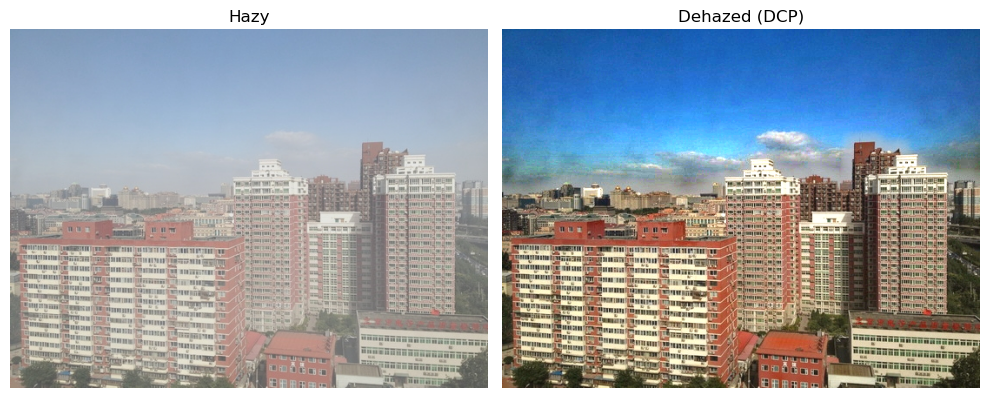

In [39]:
# 选一张室外 hazy 图测试
sample_name = sorted(os.listdir(SOTS_OUT_HAZY))[1]
sample_path = os.path.join(SOTS_OUT_HAZY, sample_name)
print(sample_name)

J = dehaze_dcp(sample_path)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
hazy = cv2.cvtColor(cv2.imread(sample_path), cv2.COLOR_BGR2RGB)

axs[0].imshow(hazy)
axs[0].set_title("Hazy")
axs[0].axis("off")

axs[1].imshow(J)
axs[1].set_title("Dehazed (DCP)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


In [40]:
for fname in tqdm(sorted(os.listdir(SOTS_OUT_HAZY))):
    if not (fname.endswith(".png") or fname.endswith(".jpg")):
        continue
    in_path = os.path.join(SOTS_OUT_HAZY, fname)
    out_path = os.path.join(RESULT_DCP_OUT, fname)
    J = dehaze_dcp(in_path, size=31, omega=0.88, t0=0.15) # 最优参数
    cv2.imwrite(out_path, cv2.cvtColor(J, cv2.COLOR_RGB2BGR))
len(os.listdir(RESULT_DCP_OUT))


100%|██████████| 501/501 [00:12<00:00, 39.31it/s]


501

In [43]:
import pandas as pd
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm
import os

rows = []

for fname in tqdm(sorted(os.listdir(SOTS_OUT_HAZY)), desc="Computing PSNR/SSIM"):
    # 支持 jpg 和 png
    if not (fname.endswith(".png") or fname.endswith(".jpg")):
        continue

    # hazy 路径
    hazy_path = os.path.join(SOTS_OUT_HAZY, fname)

    # gt 文件名匹配：只取前缀
    base = fname.split("_")[0]     # 比如 '0001'
    gt_name = base + ".png"
    gt_path = os.path.join(SOTS_OUT_GT, gt_name)

    # DCP 结果路径（同 hazy 文件名）
    dcp_path = os.path.join(RESULT_DCP_OUT, fname)

    # 文件不存在就跳过
    if not (os.path.exists(gt_path) and os.path.exists(dcp_path)):
        # print("Missing:", gt_path, dcp_path)
        continue

    # 读图
    gt  = cv2.cvtColor(cv2.imread(gt_path),  cv2.COLOR_BGR2RGB)
    dcp = cv2.cvtColor(cv2.imread(dcp_path), cv2.COLOR_BGR2RGB)

    # 尺寸不一致就 resize
    if gt.shape != dcp.shape:
        dcp = cv2.resize(dcp, (gt.shape[1], gt.shape[0]))

    # 计算 PSNR / SSIM
    psnr = peak_signal_noise_ratio(gt, dcp, data_range=255)
    ssim = structural_similarity(gt, dcp, data_range=255, channel_axis=2)

    rows.append((fname, gt_name, psnr, ssim))

# 保存结果
df_outdoor = pd.DataFrame(rows, columns=["hazy_file", "gt_file", "psnr", "ssim"])
df_outdoor.to_csv("../metrics/dcp_sots_outdoor_psnr_ssim.csv", index=False)

df_outdoor.head(), df_outdoor[["psnr","ssim"]].describe()


Computing PSNR/SSIM: 100%|██████████| 501/501 [00:35<00:00, 13.93it/s]


(            hazy_file   gt_file       psnr      ssim
 0    0001_0.8_0.2.jpg  0001.png  23.532057  0.943847
 1   0002_0.8_0.08.jpg  0002.png  18.134490  0.893975
 2    0003_0.8_0.2.jpg  0003.png  22.595719  0.930730
 3   0004_0.9_0.12.jpg  0004.png  21.604749  0.911175
 4  0006_0.85_0.08.jpg  0006.png  18.724676  0.917744,
              psnr        ssim
 count  500.000000  500.000000
 mean    20.336018    0.900302
 std      3.045331    0.036166
 min     11.772512    0.717006
 25%     18.270659    0.878746
 50%     20.488268    0.905778
 75%     22.340602    0.925622
 max     31.077376    0.971411)

In [20]:
#仅用了OUT尝试调参
from tqdm.notebook import tqdm
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# 先只用 50 张图测试（避免一次性跑太多）
hazy_list_small = hazy_list[:50]
print("Using", len(hazy_list_small), "images for debugging")

patch_sizes = [7, 15, 31]
omegas = [0.88, 0.95, 0.98]
t0_values = [0.05, 0.1, 0.15]


results = []

for size in patch_sizes:
    for omega in omegas:
        for t0 in t0_values:

            print(f"Testing params: size={size}, omega={omega}, t0={t0}")

            psnr_list = []
            ssim_list = []

            for fname in tqdm(hazy_list_small, desc="Testing images"):
                hazy_path = os.path.join(SOTS_OUT_HAZY, fname)
                base = fname.split("_")[0]
                gt_path = os.path.join(SOTS_OUT_GT, base + ".png")

                if not os.path.exists(gt_path):
                    continue

                # run DCP
                J = dehaze_dcp(hazy_path, size=size, omega=omega, t0=t0)

                gt = cv2.cvtColor(cv2.imread(gt_path), cv2.COLOR_BGR2RGB)

                if gt.shape != J.shape:
                    J = cv2.resize(J, (gt.shape[1], gt.shape[0]))

                psnr = peak_signal_noise_ratio(gt, J, data_range=255)
                ssim = structural_similarity(gt, J, data_range=255, channel_axis=2)

                psnr_list.append(psnr)
                ssim_list.append(ssim)

            results.append({
                "patch": size,
                "omega": omega,
                "t0": t0,
                "psnr_mean": np.mean(psnr_list),
                "ssim_mean": np.mean(ssim_list)
            })

import pandas as pd

df_params = pd.DataFrame(results)
df_params


Using 50 images for debugging
Testing params: size=7, omega=0.88, t0=0.05


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=7, omega=0.88, t0=0.1


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=7, omega=0.88, t0=0.15


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=7, omega=0.95, t0=0.05


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=7, omega=0.95, t0=0.1


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=7, omega=0.95, t0=0.15


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=7, omega=0.98, t0=0.05


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=7, omega=0.98, t0=0.1


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=7, omega=0.98, t0=0.15


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=15, omega=0.88, t0=0.05


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=15, omega=0.88, t0=0.1


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=15, omega=0.88, t0=0.15


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=15, omega=0.95, t0=0.05


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=15, omega=0.95, t0=0.1


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=15, omega=0.95, t0=0.15


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=15, omega=0.98, t0=0.05


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=15, omega=0.98, t0=0.1


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=15, omega=0.98, t0=0.15


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=31, omega=0.88, t0=0.05


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=31, omega=0.88, t0=0.1


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=31, omega=0.88, t0=0.15


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=31, omega=0.95, t0=0.05


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=31, omega=0.95, t0=0.1


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=31, omega=0.95, t0=0.15


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=31, omega=0.98, t0=0.05


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=31, omega=0.98, t0=0.1


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

Testing params: size=31, omega=0.98, t0=0.15


Testing images:   0%|          | 0/50 [00:00<?, ?it/s]

,patch,omega,t0,psnr_mean,ssim_mean
0,7,0.88,0.05,17.125652,0.860970
1,7,0.88,0.10,17.125652,0.860970
2,7,0.88,0.15,17.136323,0.861646
3,7,0.95,0.05,14.128484,0.765512
4,7,0.95,0.10,14.213297,0.770273
5,7,0.95,0.15,14.526812,0.784084
6,7,0.98,0.05,12.592555,0.694518
7,7,0.98,0.10,12.949760,0.709522
8,7,0.98,0.15,13.517552,0.732047
9,15,0.88,0.05,18.646584,0.880587
